In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
sys.path.append("..")

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from collections import OrderedDict
from src.config import cfg

In [6]:
processed_path = cfg.processed_path
batch_size = cfg.batch_size
epochs = cfg.epochs
base_learning_rate = cfg.base_learning_rate
gamma = cfg.gamma
power = cfg.power
weight_decay = cfg.weight_decay
num_of_tries = cfg.num_of_tries

In [7]:
# Set up place to download pretrained model from internet
import os
os.environ['TORCH_HOME'] = '../models/pretrained/'

In [8]:
from src.data.dataload import DataLoader
from src.data.datasplit import DataSplit
from src.data.dataload import FaceToBMIDataset

In [9]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Set this when run on laptop otherwise comment it out
train_on_gpu = False

CUDA is not available.  Training on CPU ...


In [10]:
print("Loading data ....")
total_dataset = torch.load(processed_path+"total_dataset.pt")
print("Done!")

Loading data ....
Done!


In [11]:
model = models.resnet50(pretrained=True)
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [12]:
for param in model.parameters():
  param.requires_grad = False

from collections import OrderedDict

fc = nn.Sequential(OrderedDict([
    ("output", nn.Linear(2048, 1))
]))

model.fc = fc
print(model.fc)
torch.save(model.state_dict(), '../models/pretrained/init_model.pt')

Sequential(
  (output): Linear(in_features=2048, out_features=1, bias=True)
)


In [13]:
def train_val_test_split():
    print("Loading data!")
    split = DataSplit(total_dataset, shuffle=True)
    train_loader, valid_loader, test_loader = split.get_split(batch_size=batch_size)
    valid_loader.dataset.set_transform("val")
    train_loader.dataset.set_transform("train")
    test_loader.dataset.set_transform("test")
    return train_loader, valid_loader, test_loader

def get_criterion():
    #Setting criterion and loggin
    criterion = nn.SmoothL1Loss()
    if train_on_gpu:
        criterion.cuda()
    return criterion

def get_optimizer(epoch):
    learning_rate = base_learning_rate*(1+gamma*epoch)**(-power)
    optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    return optimizer

def get_test_criterion():
    test_criterion = nn.L1Loss()
    if train_on_gpu: test_criterion = test_criterion.cuda()
    return test_criterion

def get_model():
    model.load_state_dict(torch.load('../models/pretrained/init_model.pt'));
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        model.cuda()
        print("Model's moved in GPU!")

In [14]:
print(f"Randomly training for {num_of_tries} times!")
test_losses = []
for current_try in range(num_of_tries):
    train_losses, valid_losses = [], []
    get_model()
    train_loader, valid_loader, test_loader = train_val_test_split()
    criterion = get_criterion()
    valid_loss_min = np.Inf
    print(f"Training {current_try+1}=th try...")
    for epoch in range(epochs):
        optimizer = get_optimizer(epoch)
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for images, _, _, bmi in train_loader:
            if train_on_gpu: images, bmi = images.cuda(), bmi.cuda()
            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, bmi)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*images.size(0)
        ######################    
        # validate the model #
        ######################
        else:
            with torch.no_grad():
                model.eval()
                for images, _, _, bmi in valid_loader:
                    # move tensors to GPU if CUDA is available
                    if train_on_gpu:
                        images, bmi = images.cuda(), bmi.cuda()                   
                    #Run model
                    predictions = model(images)
                    loss = criterion(predictions,bmi)
                    valid_loss += loss.item()*images.size(0)
        
            train_loss = train_loss/len(train_loader.sampler)
            valid_loss = valid_loss/len(valid_loader.sampler)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            # print(
            #     "Epoch: {}/{}..".format(epoch+1, epochs),
            #     "Training loss: {:.3f}".format(train_loss),
            #     "Validating loss: {:.3f}".format(valid_loss)
            # )
            if valid_loss <= valid_loss_min: # save model if validation loss has decreased
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
                torch.save(model.state_dict(), '../models/trained/best_model.pt') # for testing
                valid_loss_min = valid_loss
    ##################
    # test the model #
    ##################
    test_loss = 0.0
    test_criterion = get_test_criterion()
    print("Testing...")
    with torch.no_grad():
        model.eval()
        for images, _, _, bmi in test_loader:
            if train_on_gpu: images, bmi = images.cuda(), bmi.cuda()
            predictions = model(images)
            loss = test_criterion(predictions, bmi)
            test_loss += loss.item()*images.size(0)

    # average test loss
    test_loss = test_loss/len(test_loader.sampler)
    print('Test Loss of {}-th try: {:.3f}\n'.format(current_try+1, test_loss))
    test_losses.append(test_loss)

Randomly training for 5 times!
Loading data!
Using validation transformation
Using train transformation
Using validation transformation
Training 1=th try...
Validation loss decreased (inf --> 19.714173).  Saving model ...
Testing...
Test Loss of 1-th try: 21.114

Loading data!
Using validation transformation
Using train transformation
Using validation transformation
Training 2=th try...
Validation loss decreased (inf --> 20.753693).  Saving model ...
Testing...
Test Loss of 2-th try: 21.073

Loading data!
Using validation transformation
Using train transformation
Using validation transformation
Training 3=th try...
Validation loss decreased (inf --> 20.253609).  Saving model ...
Testing...
Test Loss of 3-th try: 20.700

Loading data!
Using validation transformation
Using train transformation
Using validation transformation
Training 4=th try...
Validation loss decreased (inf --> 19.521606).  Saving model ...
Testing...
Test Loss of 4-th try: 21.188

Loading data!
Using validation transf

In [15]:
t = list(range(1, num_of_tries+1))
test_df = pd.DataFrame(list(zip(t, test_losses)), columns=['Try-th', 'Test loss'])
test_df

,Try-th,Test loss
0,1,21.113690
1,2,21.073116
2,3,20.700173
3,4,21.188268
4,5,20.769567


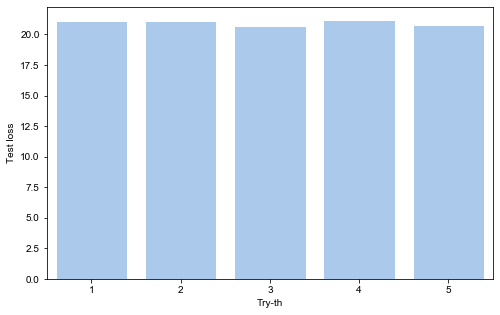

In [16]:
import seaborn as sns
f, ax = plt.subplots(figsize=(8, 5))
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x="Try-th", y="Test loss", data=test_df, color='b', label="Test");

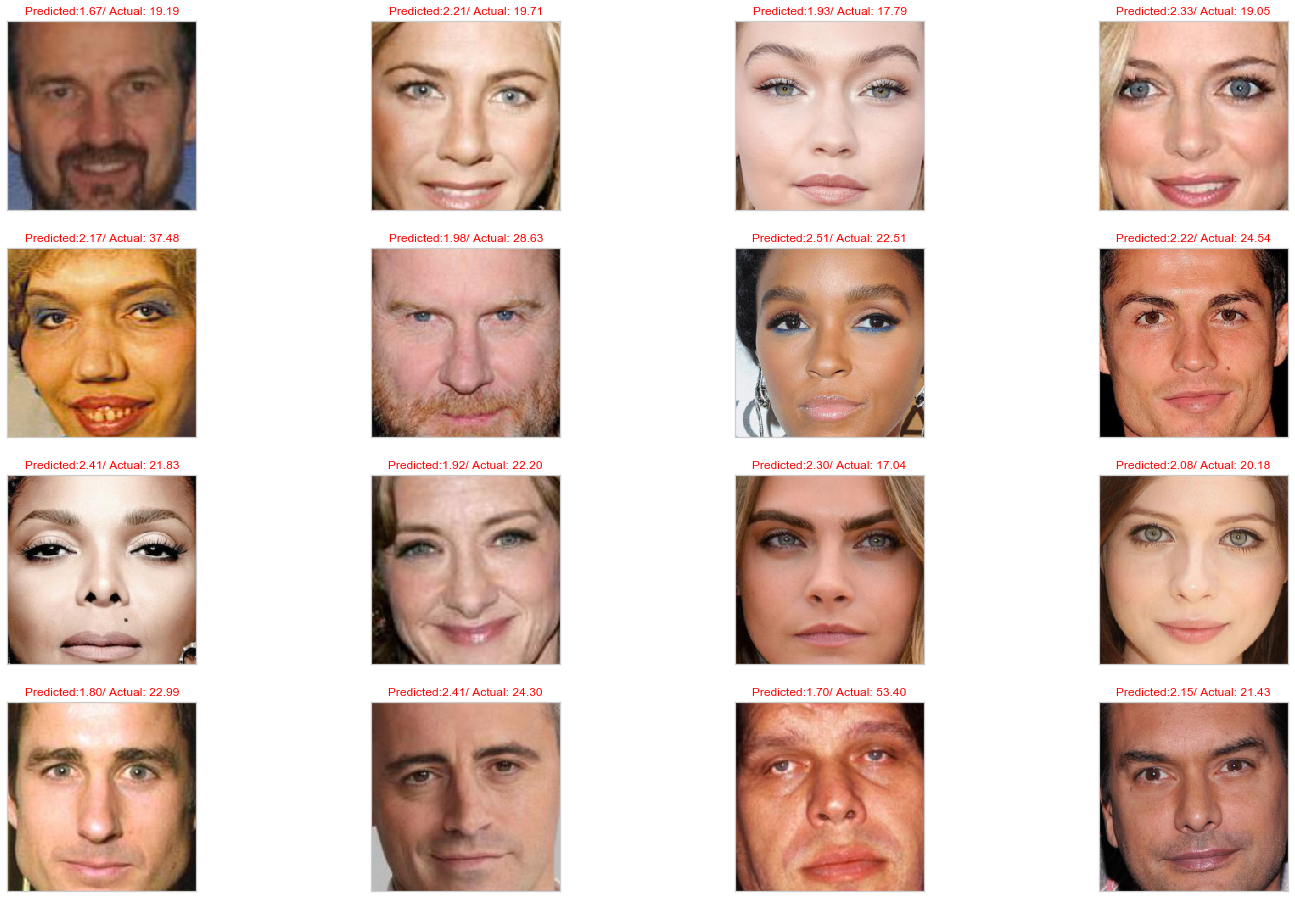

In [17]:
model.load_state_dict(torch.load('../models/trained/best_model.pt'));

# obtain one batch of test images
images, height, weight, bmi = next(iter(test_loader))

# get sample predictions
predictions = model(images)

# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, cfg.batch_size))

for idx in np.arange(cfg.batch_size):
    ax = fig.add_subplot(4, cfg.batch_size/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx,:], (1,2,0)))
    ax.set_title(
        "Predicted:{:.2f}/ Actual: {:.2f}".format(predictions[idx,:].item(), bmi[idx,:].item()), 
                    color=("green" if predictions[idx,:].item() == bmi[idx,:].item() else "red"))